<a href="https://colab.research.google.com/github/ayushs0911/Object-Detection/blob/main/Yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fcd84e7b-5a92-b4e6-5de8-4a58e492409d)


In [ ]:
import numpy as np 
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import random
import json
from sklearn.model_selection import train_test_split
import shutil
import yaml

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d mistag/arthropod-taxonomy-orders-object-detection-dataset

100% 11.1G/11.1G [01:08<00:00, 191MB/s]
100% 11.1G/11.1G [01:08<00:00, 175MB/s]


In [ ]:
!unzip /content/arthropod-taxonomy-orders-object-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: ArTaxOr/Lepidoptera/c9b07301ed0e.jpg  
  inflating: ArTaxOr/Lepidoptera/c9d742746b8a.jpg  
  inflating: ArTaxOr/Lepidoptera/c9d78061b77d.jpg  
  inflating: ArTaxOr/Lepidoptera/ca2ff8921244.jpg  
  inflating: ArTaxOr/Lepidoptera/ca338092c0ec.jpg  
  inflating: ArTaxOr/Lepidoptera/ca35e5c89d94.jpg  
  inflating: ArTaxOr/Lepidoptera/ca4cb66fcd4a.jpg  
  inflating: ArTaxOr/Lepidoptera/ca5e1fe4cbc0.jpg  
  inflating: ArTaxOr/Lepidoptera/ca5e2a4139c0.jpg  
  inflating: ArTaxOr/Lepidoptera/ca63af0a9774.jpg  
  inflating: ArTaxOr/Lepidoptera/ca652f69b2e7.jpg  
  inflating: ArTaxOr/Lepidoptera/ca95914f205e.jpg  
  inflating: ArTaxOr/Lepidoptera/ca997241704b.jpg  
  inflating: ArTaxOr/Lepidoptera/cb0ad7fb32fa.jpg  
  inflating: ArTaxOr/Lepidoptera/cb0aec5a6b79.jpg  
  inflating: ArTaxOr/Lepidoptera/cb134256077c.jpg  
  inflating: ArTaxOr/Lepidoptera/cb22cb2317b4.jpg  
  inflating: ArTaxOr/Lepidoptera/cb35eb6c2e67.jpg  
  inflating: 

#Converting annotations into DataFrames

In [ ]:
BASE_DIR = "/content/"
annotation_list = glob("/content/ArTaxOr/*/annotations/*.json")

In [ ]:
data = pd.DataFrame()
data['annotation_dir'] = annotation_list

In [ ]:
data.head()

annotation_dir
0  /content/ArTaxOr/Coleoptera/annotations/397741...
1  /content/ArTaxOr/Coleoptera/annotations/433bac...
2  /content/ArTaxOr/Coleoptera/annotations/022d3a...
3  /content/ArTaxOr/Coleoptera/annotations/36a6aa...
4  /content/ArTaxOr/Coleoptera/annotations/e1a410...

This function reads object detection data from a JSON file and returns a dictionary containing the required data. Here is a brief explanation of what this function does:

- It creates a dictionary named `rows` to store the extracted data.
- It opens the JSON file and reads its contents using the `json` library.
- For each region (i.e., object) in the JSON file, it extracts the following information:
  - The image directory.
  - The species type.
  - The image width and height.
  - The normalized bounding box height, width, left, and top coordinates.
  - The x and y center coordinates of the bounding box.
- It returns the `rows` dictionary containing the extracted data.

Overall, this function is used to read the object detection data from a JSON file and prepare it for use in training an object detection model.

In [ ]:
def read_json_data(jsonfile):
    rows = {"img_dir":[] ,"img_w":[] , "img_h" : [], "sp_type": [] ,"xc":[] , "yc":[], "bb_height" : [] , "bb_width": [] , "bb_left":[] , "bb_top":[]}
    
    # read file
    json_f = open(jsonfile)
    json_f = json.load(json_f)
 
    for region in json_f["regions"]:
        img_dir = json_f["asset"]["path"][7:]
        
        sp_type = region["tags"][0]
        
        img_w = json_f["asset"]["size"]["width"]
        img_h = json_f["asset"]["size"]["height"]
        
        # Normalize Bounding Box 
        bb_height = region["boundingBox"]["height"] / img_h
        bb_width = region["boundingBox"]["width"] / img_w
        
        bb_left = region["boundingBox"]["left"] / img_w
        bb_top = region["boundingBox"]["top"] / img_h
        
        xcenter = region['boundingBox']['left']/img_w+0.5*bb_width
        ycenetr = region['boundingBox']['top']/img_h+0.5*bb_height
        
        rows["img_dir"].append(BASE_DIR+img_dir)
        rows["sp_type"].append(sp_type)
        rows["img_w"].append(img_w)
        rows["img_h"].append(img_h)
        rows["bb_height"].append(bb_height)
        rows["bb_width"].append(bb_width)
        rows["bb_left"].append(bb_left)
        rows["bb_top"].append(bb_top)
        rows["xc"].append(xcenter)
        rows["yc"].append(ycenetr)

    return rows

In [ ]:
df = pd.DataFrame()

In [ ]:
read_json_data("/content/ArTaxOr/Coleoptera/annotations/ee94e248ec9e55792441e992fff5bf10-asset.json")

{'img_dir': ['/content//ArTaxOr/Coleoptera/6d19af862305.jpg'],
 'img_w': [2048],
 'img_h': [1365],
 'sp_type': ['Coleoptera'],
 'xc': [0.49586492074431426],
 'yc': [0.5140253360910032],
 'bb_height': [0.13547052740434334],
 'bb_width': [0.10268780151619572],
 'bb_left': [0.4445210199862164],
 'bb_top': [0.4462900723888315]}

In [ ]:
for json_file in tqdm(data["annotation_dir"]):
  rows = read_json_data(json_file)
  df = df.append(df.from_dict(rows))

  0%|          | 0/15376 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-23-7d6e25aea817>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df.from_dict(rows))
<ipython-input-23-7d6e25aea817>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df.from_dict(rows))
<ipython-input-23-7d6e25aea817>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df.from_dict(rows))
<ipython-input-23-7d6e25aea817>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df.from_dict(rows))
<ipython-input-23-7d6e25aea817>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [ ]:
df = df.reset_index(drop = True)
df.head()

img_dir  img_w  img_h     sp_type  \
0  /content//ArTaxOr/Coleoptera/8f6b67c7f386.jpg    931    870  Coleoptera   
1  /content//ArTaxOr/Coleoptera/8f6b67c7f386.jpg    931    870  Coleoptera   
2  /content//ArTaxOr/Coleoptera/022b217a27e4.jpg    945   1218  Coleoptera   
3  /content//ArTaxOr/Coleoptera/29f2b1cb5e17.jpg   2872   1839  Coleoptera   
4  /content//ArTaxOr/Coleoptera/1fb96e3807f8.jpg   2048   1365  Coleoptera   

         xc        yc  bb_height  bb_width   bb_left    bb_top  
0  0.243607  0.181992   0.124521  0.155774  0.165720  0.119732  
1  0.502336  0.607280   0.421456  0.404655  0.300008  0.396552  
2  0.545062  0.465996   0.520115  0.461728  0.314198  0.205939  
3  0.481737  0.591025   0.681378  0.818746  0.072364  0.250336  
4  0.481392  0.552805   0.068252  0.036527  0.463129  0.518679

<Axes: >

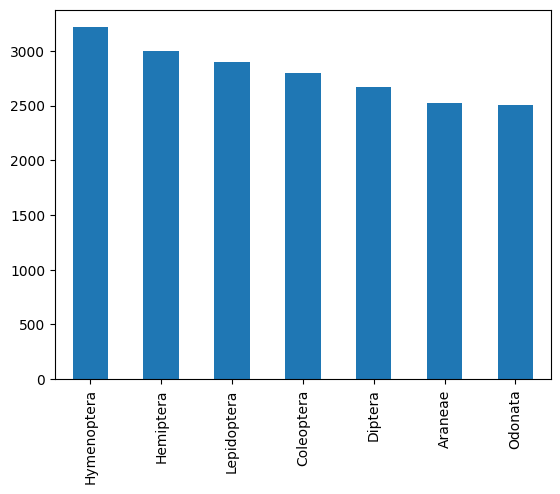

In [ ]:
df['sp_type'].value_counts().plot(kind = 'bar')

#Data Visualization 

In [ ]:
def display_random_imgs(df , rows , cols):
  idxs = random.sample(df.index.tolist() , rows*cols)
  fig , ax = plt.subplots(rows , cols ,figsize = (10,10))
  if rows*cols != 1:
    for count , axs in enumerate(ax.flatten()):
      path = df.img_dir.iloc[idxs[count]]
      patch = patches.Rectangle((df.bb_left.iloc[idxs[count]] * df.img_w.iloc[idxs[count]],
                                  df.bb_top.iloc[idxs[count]]* df.img_h.iloc[idxs[count]]),
                                df.bb_width.iloc[idxs[count]]* df.img_w.iloc[idxs[count]],
                                df.bb_height.iloc[idxs[count]]* df.img_h.iloc[idxs[count]],
                                linewidth=1, edgecolor='r', facecolor='none')
      img = plt.imread(path)
      axs.imshow(img)
      axs.add_patch(patch)
      axs.axis('off')
      axs.title.set_text(df.sp_type.iloc[idxs[count]])

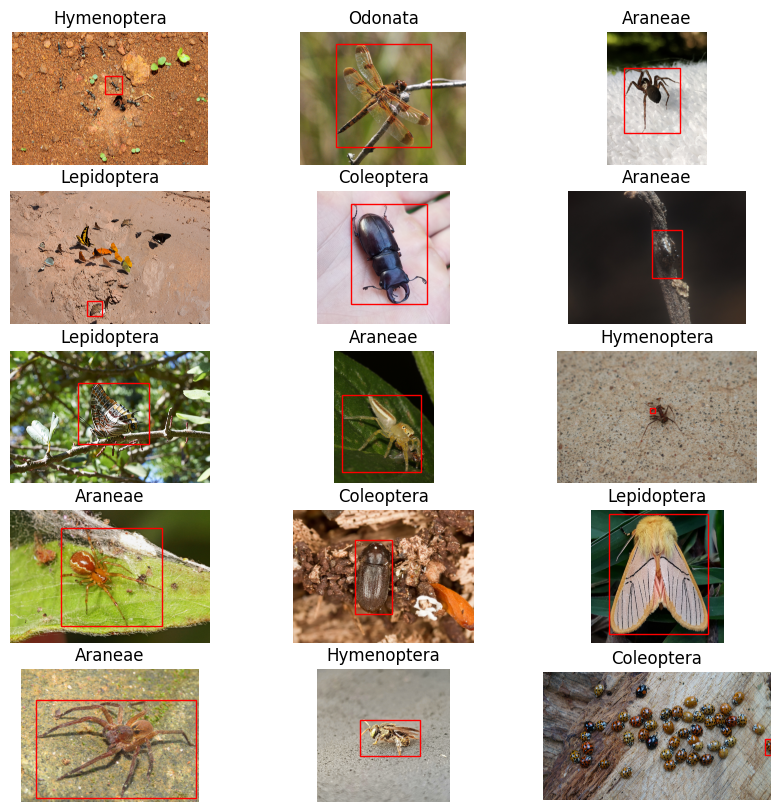

In [ ]:
display_random_imgs(df ,5, 3)

In [ ]:
classes_name = ["Hymenoptera","Hemiptera","Lepidoptera","Coleoptera","Diptera","Araneae","Odonata"]
classes_num = [0,1,2,3,4,5,6]

df.sp_type = df.sp_type.replace(classes_name , classes_num)

In [ ]:
train, test = train_test_split(df, test_size = 0.2)

In [ ]:
!mkdir data 
!mkdir data/train
!mkdir data/test

In [ ]:
def add_data_to_folder(file_type, data):
    for index, row  in tqdm(data.iterrows(),total=len(data)):
        shutil.copy(row["img_dir"] , f"/content/data/{file_type}")
        with open(f'/content/data/{file_type}/{row.img_dir.split("/")[-1][:-4]}.txt' , "w") as f:
            f.write(str(row["sp_type"]))
            f.write(" ")
            f.write(str(row["xc"]))
            f.write(" ")
            f.write(str(row["yc"]))
            f.write(" ")
            f.write(str(row["bb_width"]))
            f.write(" ")
            f.write(str(row["bb_height"]))
            f.write("\n")
            f.close()

In [ ]:
add_data_to_folder("train/" , train)
add_data_to_folder("test/" , test)

  0%|          | 0/15684 [00:00<?, ?it/s]

  0%|          | 0/3921 [00:00<?, ?it/s]

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!mv yolov5/* ./

Cloning into 'yolov5'...
remote: Enumerating objects: 15639, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 15639 (delta 120), reused 141 (delta 68), pack-reused 15393
Receiving objects: 100% (15639/15639), 14.59 MiB | 29.41 MiB/s, done.
Resolving deltas: 100% (10649/10649), done.
mv: cannot move 'yolov5/data' to './data': Directory not empty


In [ ]:
# create yml file
yaml_dict = dict(
    train = '/content/data/train',
    val = '/content/data/test',
    
    nc    = len(classes_num), # number of classes
    names = classes_name # classes
    )

with open('/content/data.yaml', 'w') as outfile:
    yaml.dump(yaml_dict, outfile, default_flow_style=False)

%cat /content/data.yaml

names:
- Hymenoptera
- Hemiptera
- Lepidoptera
- Coleoptera
- Diptera
- Araneae
- Odonata
nc: 7
train: /content/data/train
val: /content/data/test


In [ ]:
! pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import ultralytics
from IPython import display
display.clear_output()
!yolo checks

Ultralytics YOLOv8.0.91 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 58.2/78.2 GB disk)


In [ ]:
from ultralytics import YOLO


In [ ]:
# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)
batch_size = 32
imgsz = 640

100%|██████████| 6.23M/6.23M [00:00<00:00, 69.9MB/s]


In [ ]:
del df , data

In [ ]:
# Use the model
results = model.train(data="data.yaml", 
                      epochs = 1 , 
                      batch = batch_size , 
                      imgsz=imgsz)  # train the model

Ultralytics YOLOv8.0.91 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=1, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, workspace=4

In [ ]:
model.val()

Ultralytics YOLOv8.0.91 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007013 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/data/test.cache... 3513 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3513/3513 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [05:43<00:00,  3.12s/it]
                   all       3513       3513      0.293      0.432      0.302      0.192
           Hymenoptera       3513        543      0.208     0.0958      0.115       0.07
             Hemiptera       3513        553      0.342      0.532      0.346      0.233
           Lepidoptera       3513        506      0.236      0.508      0.274      0.177
            Coleoptera       3513        526      0.317      0.257      0.212      0.136
               Diptera       3513        443      0.207      0.532      0.257      0.179
               Araneae       3513  

ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7fa23b3b3ee0>
fitness: 0.20341983522701182
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([   0.070022,     0.23276,     0.17682,      0.1362,     0.17931,     0.17836,     0.37385])
names: {0: 'Hymenoptera', 1: 'Hemiptera', 2: 'Lepidoptera', 3: 'Coleoptera', 4: 'Diptera', 5: 'Araneae', 6: 'Odonata'}
plot: True
results_dict: {'metrics/precision(B)': 0.2934645736737796, 'metrics/recall(B)': 0.43180708837848797, 'metrics/mAP50(B)': 0.30193446459612583, 'metrics/mAP50-95(B)': 0.19247376529711027, 'fitness': 0.20341983522701182}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 0.37995030864364837, 'inference': 3.7973410310210443, 'loss': 0.0007301187230215227, 'postprocess': 2.542680

In [ ]:
from PIL import Image

In [ ]:
im = Image.open("/content/ArTaxOr/Lepidoptera/00026d79d067.jpg")

In [ ]:
results = model.predict(im, save = True)


0: 448x640 1 Diptera, 1 Odonata, 21.1ms
Speed: 3.8ms preprocess, 21.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


In [ ]:
results = model.predict(Image.open("/content/data/test/00600a41bcaf.jpg"), save = True)


0: 640x480 1 Hemiptera, 1 Lepidoptera, 23.7ms
Speed: 7.0ms preprocess, 23.7ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


In [ ]:
from glob import glob
from os import path

In [ ]:
model = YOLO("/content/runs/detect/train/weights/best.pt")

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
! kaggle datasets download -d mistag/arthropod-taxonomy-orders-object-detection-testset

 75% 25.0M/33.5M [00:00<00:00, 76.8MB/s]
100% 33.5M/33.5M [00:00<00:00, 85.3MB/s]


In [ ]:
!unzip arthropod-taxonomy-orders-object-detection-testset

Archive:  arthropod-taxonomy-orders-object-detection-testset.zip
  inflating: ArTaxOr_TestSet/license.txt  
  inflating: ArTaxOr_TestSet/negatives/4e8a3e2629e2.jpg  
  inflating: ArTaxOr_TestSet/negatives/56d121e7ab91.jpg  
  inflating: ArTaxOr_TestSet/negatives/a3c245ccd3a2.jpg  
  inflating: ArTaxOr_TestSet/negatives/abc25d55d24b.jpg  
  inflating: ArTaxOr_TestSet/negatives/ede91929e20c.jpg  
  inflating: ArTaxOr_TestSet/negatives/f37b8413c525.jpg  
  inflating: ArTaxOr_TestSet/positives/1d9c19837543.jpg  
  inflating: ArTaxOr_TestSet/positives/2f863e23deac.jpg  
  inflating: ArTaxOr_TestSet/positives/310304cfbc6e.jpg  
  inflating: ArTaxOr_TestSet/positives/4639e5dfdbcb.jpg  
  inflating: ArTaxOr_TestSet/positives/506dac891844.jpg  
  inflating: ArTaxOr_TestSet/positives/58e9db06f160.jpg  
  inflating: ArTaxOr_TestSet/positives/5c561eb545ef.jpg  
  inflating: ArTaxOr_TestSet/positives/78f770a91e9d.jpg  
  inflating: ArTaxOr_TestSet/positives/7e9efdf97033.jpg  
  inflating: ArTaxOr_T

In [ ]:
test_set = "/content/ArTaxOr_TestSet/positives"

test_images = [Image.open(jpg) for jpg in glob(path.join(test_set, '*.jpg'))]

In [ ]:
for img in test_images:
  results = model.predict(img, save = True)


0: 640x640 (no detections), 25.0ms
Speed: 12.5ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2

0: 480x640 (no detections), 98.4ms
Speed: 3.7ms preprocess, 98.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2

0: 640x448 1 Lepidoptera, 84.4ms
Speed: 3.6ms preprocess, 84.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2

0: 480x640 1 Diptera, 16.2ms
Speed: 3.5ms preprocess, 16.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2

0: 448x640 1 Lepidoptera, 13.7ms
Speed: 3.4ms preprocess, 13.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2

0: 544x640 1 Diptera, 70.0ms
Speed: 3.8ms preprocess, 70.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detec

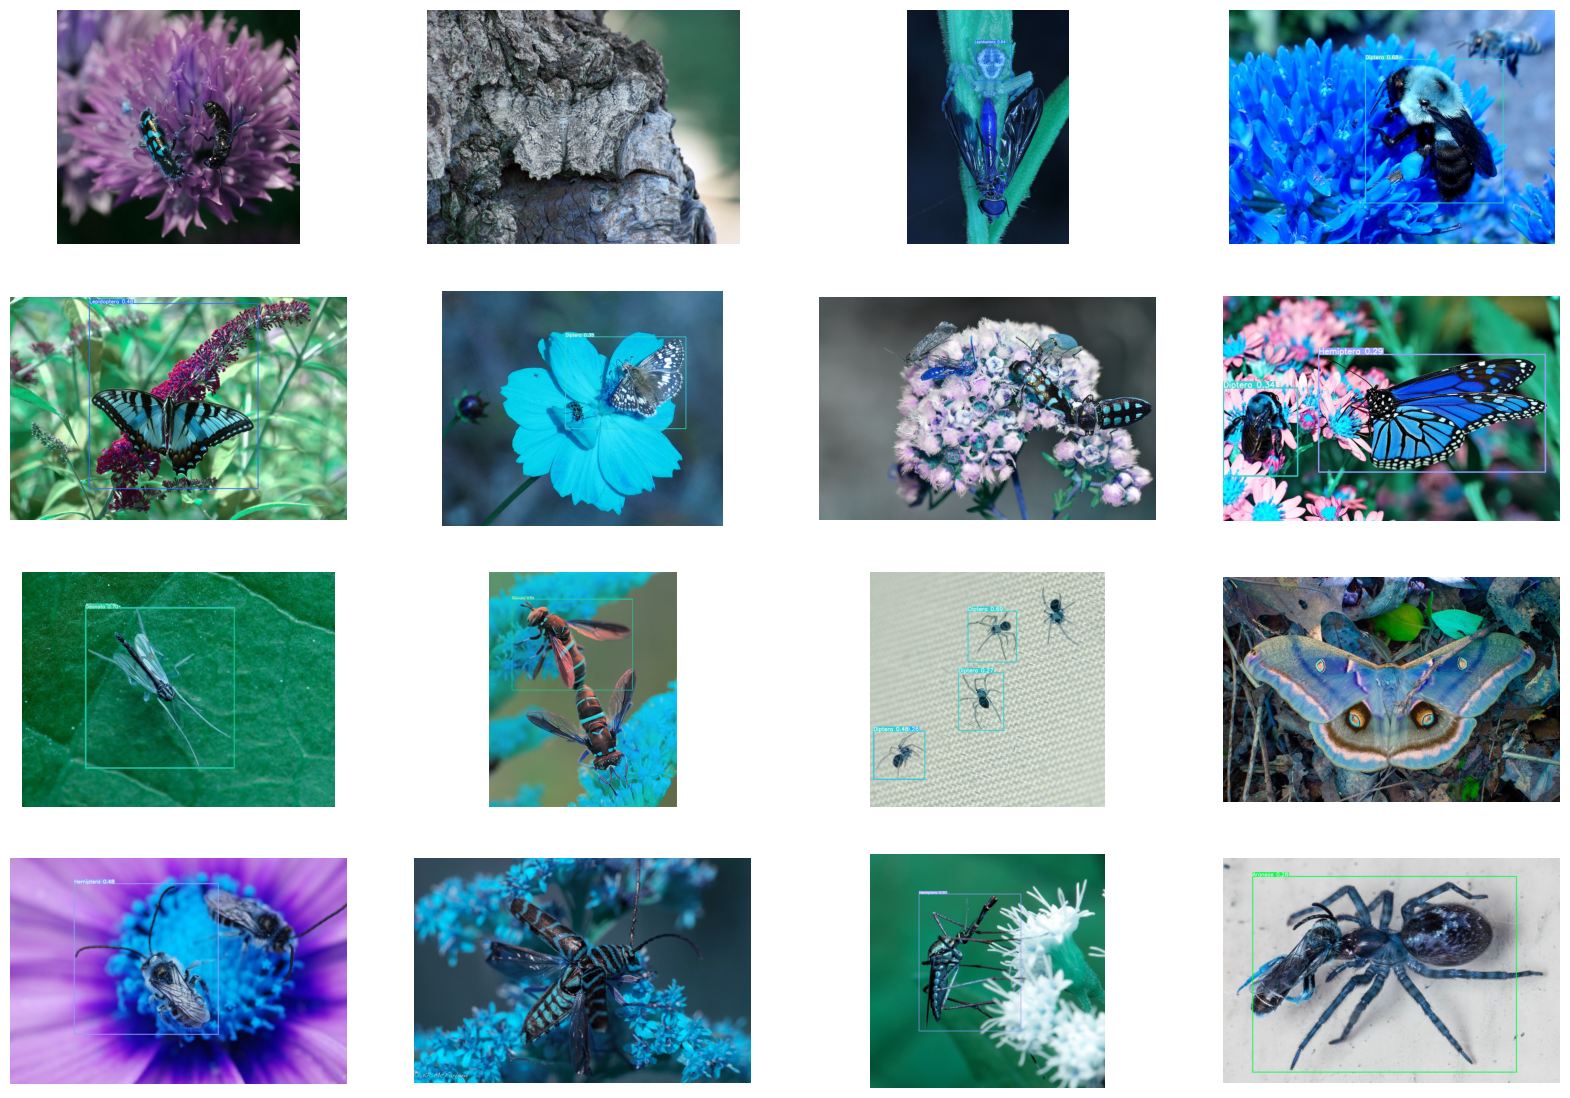

In [ ]:
output = "/content/runs/detect/predict2"
plt.figure(figsize = (20,14))
for i, filename in enumerate(os.listdir(output)):
  img = cv2.imread(os.path.join(output, filename))
  ax = plt.subplot(4,4,i+1)
  plt.imshow(img)
  plt.axis('off')
  if i == 15:
    break

In [ ]:
model.export(format='onnx', dynamic=True)

Ultralytics YOLOv8.0.91 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU

PyTorch: starting from /content/runs/detect/train/weights/best.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 11, 8400) (5.9 MB)
requirements: YOLOv8 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 115.6 MB/s eta 0:00:00

requirements: 1 package updated per ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.13.1 opset 17...
ONNX: export success ✅ 11.2s, saved as /content/runs/detect/train/weights/best.onnx (11.5 MB)

Export complete (12.0s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=/content/runs/detect/

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'/content/runs/detect/train/weights/best.onnx'